In [128]:
import duckdb
from collections import defaultdict, Counter
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import LeaveOneOut
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import coo_matrix
import ast
import random
import implicit
import math

In [129]:
db = duckdb.connect(":memory:")
db.sql(f"CREATE TABLE novel AS SELECT * FROM '../eda/data/novels_0.1.5.csv';")

In [158]:
# Eval Functions

def precision_at_k(recommended, relevant, k):
    hits = sum(1 for pid in recommended[:k] if pid in relevant)
    return hits / k

def recall_at_k(recommended, relevant, k):
    hits = sum(1 for pid in recommended[:k] if pid in relevant)
    return hits / len(relevant)

def average_precision_at_k(recommended, relevant, k):
    ap, hits = 0.0, 0
    for i, pid in enumerate(recommended[:k], start=1):
        if pid in relevant:
            hits += 1
            ap += hits / i
    return ap / min(len(relevant), k)

def print_metrics(dict_truth, dict_recommend, model, K):
    precision_list = []
    recall_list = []
    ap_list = []

    for user, relevant in dict_truth.items():
        recommended = dict_recommend[user]
        
        precision_list.append(precision_at_k(recommended, relevant, K))
        recall_list.append(recall_at_k(recommended, relevant, K))
        ap_list.append(average_precision_at_k(recommended, relevant, K))

    mean_precision = sum(precision_list) / len(precision_list)
    mean_recall = sum(recall_list) / len(recall_list)
    mean_ap = sum(ap_list) / len(ap_list)

    print(f"Random {model} Precision@{K}: {mean_precision:.6f}")
    print(f"Random {model} Recall@{K}: {mean_recall:.6f}")
    print(f"Random {model} MAP@{K}: {mean_ap:.6f}")
    return (mean_precision, mean_recall, mean_ap)

In [131]:
ids = db.sql("SELECT id FROM novel").fetchall()
novel_id_to_index = {}
for (i, id) in enumerate(ids):
    novel_id_to_index[id] = i

In [132]:
rec_lists = db.sql("SELECT id, recommendation_list_ids, genres, tags FROM novel").fetchall()

rec_dict = defaultdict(list)
rec_genre = defaultdict(list)
rec_tag = defaultdict(list)
for rec_list in rec_lists:
    ids = rec_list[1]
    if ids is not None:
        split_ids = ids.split(",")
        split_genres = rec_list[2].split(",")
        clean_genres = []
        for genre in split_genres:
            clean_genre = genre.replace("[", "").replace("]","")
            if clean_genre:
                clean_genres.append(clean_genre)
        split_tags = rec_list[3].split(",")
        clean_tags = []
        for tag in split_tags:
            clean_tag = tag.replace("[", "").replace("]","")
            if clean_tag:
                clean_tags.append(clean_tag)
        for id in split_ids:
            clean_id = id.replace("[", "").replace("]","").replace(" ", "")
            rec_dict[clean_id].append(rec_list[0])
            rec_genre[clean_id] = clean_genres
            rec_tag[clean_id] = clean_tags
            

print(rec_dict)

defaultdict(<class 'list'>, {'120875': [5, 15, 6780, 9810], '120484': [5, 35, 181, 392, 1141, 4351, 7422, 74055, 10449, 14780, 18925, 29115, 32342, 98551, 99214, 36952, 104002], '120154': [5, 791, 7206, 9072, 12963, 18089, 18608, 19593, 19744, 20290, 30037, 39663, 41797, 46215, 52118, 59244], '119033': [5, 14, 428, 791, 71007, 7242, 76707, 13148, 32090, 32676, 45053], '118692': [5, 35, 38, 181, 195, 246, 67764, 68016, 2717, 3284, 68821, 68865, 3491, 4351, 5495, 5504, 5508, 6368, 6692, 72474, 6986, 7051, 73824, 8519, 9244, 9421, 9734, 77742, 13662, 80286, 16973, 18882, 84853, 19593, 87212, 21856, 25478, 32515, 32627, 34160, 34341, 37438, 37583, 37785, 41454, 41674, 42419, 45147, 45231, 46556, 47953, 48442, 50970, 54213, 59232, 62319, 64863], '45457': [65541, 899], '17662': [65541, 66202, 67286, 67395, 67455, 67743, 67788, 67834, 68545, 69075, 69389, 70303, 70337, 70721, 70878, 71043, 72849, 75652, 76062, 34084, 34189, 39856, 56255, 57579, 58866, 58960, 62475, 64959], '87891': [65543, 67

In [133]:
def normalize_text(text):
    return text.lower().replace(" ", "").replace("-", "").replace("*", "").replace("/", "").strip().strip("'")

per_user_genre_counts = {
    user: Counter(normalize_text(g) for g in genres)
    for user, genres in rec_genre.items()
}

rec_genre_df = pd.DataFrame.from_dict(per_user_genre_counts, orient='index').fillna(0).astype(int)

per_user_tag_counts = {
    user: Counter(normalize_text(t) for t in tags)
    for user, tags in rec_tag.items()
}

rec_tag_df = pd.DataFrame.from_dict(per_user_tag_counts, orient='index').fillna(0).astype(int)


In [134]:
cleaned_tag = {
    user: [normalize_text(t) for t in tags]
    for user, tags in rec_tag.items()
}

tag_vectorizer = TfidfVectorizer(
    tokenizer=lambda x: x,
    preprocessor=lambda x: x,
    token_pattern=None
)

tfidf_tag_matrix = tag_vectorizer.fit_transform(cleaned_tag.values())

df_tfidf_tag = pd.DataFrame(
    tfidf_tag_matrix.toarray(),
    index=cleaned_tag.keys(),
    columns=tag_vectorizer.get_feature_names_out()
)

df_tfidf_tag.columns.tolist()

cleaned_genre = {
    user: [normalize_text(g) for g in genres]
    for user, genres in rec_genre.items()
}

genre_vectorizer = TfidfVectorizer(
    tokenizer=lambda x: x,
    preprocessor=lambda x: x,
    token_pattern=None
)

tfidf_genre_matrix = genre_vectorizer.fit_transform(cleaned_genre.values())

df_tfidf_genre = pd.DataFrame(
    tfidf_genre_matrix.toarray(),
    index=cleaned_genre.keys(),
    columns=genre_vectorizer.get_feature_names_out()
)

df_tfidf_genre.columns.tolist()

['action',
 'adult',
 'adventure',
 'comedy',
 'drama',
 'ecchi',
 'fantasy',
 'genderbender',
 'harem',
 'historical',
 'horror',
 'josei',
 'martialarts',
 'mature',
 'mecha',
 'mystery',
 'psychological',
 'romance',
 'schoollife',
 'scifi',
 'seinen',
 'shoujo',
 'shoujoai',
 'shounen',
 'shounenai',
 'sliceoflife',
 'smut',
 'sports',
 'supernatural',
 'tragedy',
 'wuxia',
 'xianxia',
 'xuanhuan',
 'yaoi',
 'yuri']

In [135]:
user_id = '117379'

user_tfidf_tag = df_tfidf_tag.loc[user_id]

nonzero_tags = user_tfidf_tag[user_tfidf_tag > 0].sort_values(ascending=False)
print(nonzero_tags)

user_tfidf_genre = df_tfidf_genre.loc[user_id]

nonzero_genres = user_tfidf_genre[user_tfidf_genre > 0].sort_values(ascending=False)
print(nonzero_genres)

possession         0.631972
swordwielder       0.498876
adaptedtomanhwa    0.414851
calmprotagonist    0.331151
maleprotagonist    0.264521
Name: 117379, dtype: float64
wuxia          0.745237
martialarts    0.507055
adventure      0.313532
action         0.298687
Name: 117379, dtype: float64


In [136]:
# Sum TF-IDF across all users for tags
sum_tfidf_tag = df_tfidf_tag.sum(axis=0)
sum_tfidf_tag = pd.DataFrame(sum_tfidf_tag, columns=['score']).sort_values('score', ascending=False)
print("Top tags overall:")
print(sum_tfidf_tag.head(20))

# Sum TF-IDF across all users for genres
sum_tfidf_genre = df_tfidf_genre.sum(axis=0)
sum_tfidf_genre = pd.DataFrame(sum_tfidf_genre, columns=['score']).sort_values('score', ascending=False)
print("\nTop genres overall:")
print(sum_tfidf_genre.head(20))


Top tags overall:
                                   score
femaleprotagonist             721.768387
modernday                     634.819009
handsomemalelead              627.730186
beautifulfemalelead           561.876687
maleprotagonist               520.688757
transmigration                498.044608
loveinterestfallsinlovefirst  469.877871
europeanambience              361.372924
nobles                        332.755980
royalty                       323.128959
strongloveinterests           318.552142
calmprotagonist               318.383371
misunderstandings             317.611219
dotingloveinterests           316.131335
devotedloveinterests          310.770407
wealthycharacters             301.178281
aristocracy                   290.355919
cleverprotagonist             279.643936
secondchance                  277.842165
magic                         277.061841

Top genres overall:
                     score
romance        2481.975212
fantasy        2237.819823
drama          1779

In [137]:
df_tfidf_genre = df_tfidf_genre.reindex(index=df_tfidf_tag.index).fillna(0)

df_tfidf_combined = pd.concat([df_tfidf_tag, df_tfidf_genre], axis=1)

similarity_matrix = cosine_similarity(df_tfidf_combined.values, df_tfidf_combined.values)
similarity_df = pd.DataFrame(similarity_matrix, index=df_tfidf_combined.index, columns=df_tfidf_combined.index)

rec_id = "117379"
top_n = 10

similar_scores = similarity_df[rec_id].sort_values(ascending=False)
top_recommendations = similar_scores.iloc[1:top_n+1]
print(top_recommendations)


117379    1.000000
62028     0.742289
38319     0.698500
113462    0.637719
108211    0.583492
100884    0.576560
102427    0.576560
111502    0.576560
47255     0.572264
120842    0.569821
Name: 117379, dtype: float64


In [138]:
rec_lists = db.sql("SELECT id, recommendation_list_ids, genres, tags FROM novel").fetchall()
novel_genre = defaultdict(list)
novel_tag = defaultdict(list)

for novel in rec_lists:
    novel_id = novel[0]
    split_genres = novel[2].split(",")
    for genre in split_genres:
        clean_genre = genre.replace("[", "").replace("]","")
        if clean_genre:
            novel_genre[novel_id].append(clean_genre)
    split_tags = novel[3].split(",")
    for tag in split_tags:
        clean_tag = tag.replace("[", "").replace("]","")
        if clean_tag:
            novel_tag[novel_id].append(clean_tag)

cleaned_novel_tag = {
    novel: [normalize_text(t) for t in tags]
    for novel, tags in novel_tag.items()
}

cleaned_novel_genre = {
    novel: [normalize_text(g) for g in genres]
    for novel, genres in novel_genre.items()
}

novel_tag_vectorizer = TfidfVectorizer(
    tokenizer=lambda x: x,
    preprocessor=lambda x: x,
    token_pattern=None
)

novel_genre_vectorizer = TfidfVectorizer(
    tokenizer=lambda x: x,
    preprocessor=lambda x: x,
    token_pattern=None
)

tfidf_novel_tag_matrix = novel_tag_vectorizer.fit_transform(cleaned_novel_tag.values())

tfidf_novel_genre_matrix = novel_genre_vectorizer.fit_transform(cleaned_novel_genre.values())

df_tfidf_novel_tag = pd.DataFrame(
    tfidf_novel_tag_matrix.toarray(),
    index=cleaned_novel_tag.keys(),
    columns=novel_tag_vectorizer.get_feature_names_out()
)

df_tfidf_novel_genre = pd.DataFrame(
    tfidf_novel_genre_matrix.toarray(),
    index=cleaned_novel_genre.keys(),
    columns=novel_genre_vectorizer.get_feature_names_out()
)

df_tfidf_novel_all = pd.concat(
    [df_tfidf_novel_tag, df_tfidf_novel_genre],
    axis=1
).fillna(0)

def recommend_similar_novels(novel_id, top_k=5):
    target_vec = df_tfidf_novel_all.loc[[novel_id]]

    sims = cosine_similarity(target_vec, df_tfidf_novel_all)[0]
    
    sim_series = pd.Series(sims, index=df_tfidf_novel_all.index)

    sim_series = sim_series.drop(novel_id)
    return sim_series.sort_values(ascending=False).head(top_k)

# recommend_similar_novels(5, top_k=2)



In [167]:
# Stats on rec lists

max_v = 0
total = 0
min_v = 999999

for rec in rec_dict.items():
    length = len(rec[1])
    total += length
    if (length > max_v):
        max_v = length
    if (length < min_v):
        min_v = length

print("largest list", max_v) 
print("average list", total/len(rec_dict.items()))
print("smallest list", min_v)


largest list 99
average list 6.614878106137807
smallest list 1


In [140]:
rec_list_df = pd.DataFrame([
    {"rec_id": k, "novel_id": v}
    for k, values in rec_dict.items()
    for v in values
])
print(rec_list_df)

       rec_id  novel_id
0      120875         5
1      120875        15
2      120875      6780
3      120875      9810
4      120484         5
...       ...       ...
84381   70747     65302
84382   67388     65350
84383  121829     65447
84384   91247     65513
84385   90581     65532

[84386 rows x 2 columns]


In [141]:
train_rows = []
test_rows = []

for user, group in rec_list_df.groupby("rec_id"):
    if len(group) < 2:
        continue
    loo = LeaveOneOut()
    X = group["novel_id"].values.reshape(-1, 1) 
    for train_idx, test_idx in loo.split(X):
        train_rows.append(group.iloc[train_idx])
        test_rows.append(group.iloc[test_idx])
        break 

train_df = pd.concat(train_rows).reset_index(drop=True)
test_df = pd.concat(test_rows).reset_index(drop=True)

print("Train set size:", len(train_df))
print("Test set size:", len(test_df))

Train set size: 71629
Test set size: 8720


In [142]:
# Random Baseline
def random_rec(novel_dict):
    return random.choice(list(novel_dict.keys()))[0]

In [143]:
# CF Model

train_df["user_idx"] = train_df["rec_id"].astype("category").cat.codes
train_df["item_idx"] = train_df["novel_id"].astype("category").cat.codes

interaction_matrix = coo_matrix(
    ([1]*len(train_df), (train_df["user_idx"], train_df["item_idx"]))
).tocsr()

# Initialize ALS model
cf_model = implicit.als.AlternatingLeastSquares(factors=50, regularization=0.1, iterations=20)

# implicit expects item-user matrix
cf_model.fit(interaction_matrix.T)  # transpose: items x users

/Users/tylerpham/Documents/GitHub/CSC466/NovelUpdates-Recommender/.venv/lib/python3.13/site-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed csc_matrix instead. Converting to CSR took 0.00030994415283203125 seconds
  warnings.warn(
100%|██████████| 20/20 [00:00<00:00, 26.00it/s]


In [144]:
#TF-IDF Content Based Model
tfidf_matrix = df_tfidf_novel_all.values
novel_ids = df_tfidf_novel_all.index.to_list()
novel_id_to_idx = {nid: i for i, nid in enumerate(novel_ids)}
idx_to_novel_id = {i: nid for i, nid in enumerate(novel_ids)}

def get_similar_novels(novel_id, top_k=5):
    idx = novel_id_to_idx[novel_id]
    vec = tfidf_matrix[idx].reshape(1, -1)
    sims = cosine_similarity(vec, tfidf_matrix)[0]
    
    sims[idx] = -1
    
    top_idxs = sims.argsort()[::-1][:top_k]
    return [idx_to_novel_id[i] for i in top_idxs], sims[top_idxs]

def get_user_profile(novel_list):
    idxs = [novel_id_to_idx[n] for n in novel_list if n in novel_id_to_idx]
    if not idxs:
        return None
    return tfidf_matrix[idxs].mean(axis=0)

def recommend_for_user(user_novels, K=5):
    profile = get_user_profile(user_novels)
    if profile is None:
        return []

    sims = cosine_similarity(profile.reshape(1, -1), tfidf_matrix)[0]
  
    for n in user_novels:
        if n in novel_id_to_idx:
            sims[novel_id_to_idx[n]] = -1
    
    top_idxs = sims.argsort()[::-1][:K]
    return [idx_to_novel_id[i] for i in top_idxs]


In [145]:
# Fetch the raw data
novel_data = db.sql("""
    SELECT 
        id AS novel_id,
        original_language,
        genres,
        on_reading_lists
    FROM novel
""").fetchall()

df_novel = pd.DataFrame(novel_data, columns=['novel_id', 'original_language', 'genres', 'on_reading_lists'])

# Convert genres from string to list
def parse_list_column(x):
    if x:
        try:
            parsed = ast.literal_eval(x)
            if isinstance(parsed, list) and len(parsed) > 0 and isinstance(parsed[0], list):
                return parsed[0]
            return parsed
        except:
            return []
    return []

df_novel['genres'] = df_novel['genres'].apply(parse_list_column)

df_novel['on_reading_lists'] = df_novel['on_reading_lists'].astype(int)

df_novel['original_language'] = df_novel['original_language'].str.lower().str.strip()

df_novel.head()


,novel_id,original_language,genres,on_reading_lists
0,5,chinese,"[action, adventure, fantasy, seinen, xuanhuan]",13625
1,65541,chinese,"[comedy, fantasy, gender bender, psychological...",923
2,65543,japanese,"[comedy, harem, romance, school life, shounen,...",481
3,10,chinese,"[action, adventure, drama, harem, mature, smut...",15087
4,65547,korean,"[adult, comedy, drama, fantasy, romance, smut,...",976


In [146]:
import pandas as pd

def get_favorite_language(user_novels, novel_df):
    langs = novel_df.loc[novel_df['novel_id'].isin(user_novels), 'original_language']
    most_common_lang = langs.mode()
    if len(most_common_lang) > 0:
        return most_common_lang[0]
    return None

def filter_candidates(novel_df, language, user_genres=None, exclude_novels=[]):
    candidates = novel_df[novel_df['original_language'] == language].copy()
    
    if user_genres is not None:
        candidates = candidates[candidates['genres'].apply(lambda g: any(genre in g for genre in user_genres))]
    
    if exclude_novels:
        candidates = candidates[~candidates['novel_id'].isin(exclude_novels)]
    
    return candidates

def rank_by_popularity(candidates, top_k=10):
    return candidates.sort_values('on_reading_lists', ascending=False).head(top_k)

def recommend_popular_for_user(user_novels, novel_df, top_k=10):
    langs = novel_df.loc[novel_df['novel_id'].isin(user_novels), 'original_language']
    if len(langs) == 0:
        fav_lang = None
    else:
        fav_lang = langs.mode()[0]

    genres_lists = novel_df.loc[novel_df['novel_id'].isin(user_novels), 'genres']
    user_genres = []
    for glist in genres_lists:
        if isinstance(glist, list):
            user_genres.extend(glist)
    user_genres = list(set(user_genres))

    if fav_lang is None:
        candidates = novel_df.copy()
    else:
        candidates = novel_df[novel_df['original_language'] == fav_lang].copy()
        if user_genres:
            candidates = candidates[candidates['genres'].apply(lambda g: any(genre in g for genre in user_genres))]
        candidates = candidates[~candidates['novel_id'].isin(user_novels)]

    recommended = candidates.sort_values('on_reading_lists', ascending=False).head(top_k)
    return recommended['novel_id'].tolist()



In [147]:
# Some stats

db.sql("""
        SELECT 
            original_language, 
            COUNT(1) AS cnt, 
            AVG(rating), 
            AVG(rating_votes), 
            AVG(on_reading_lists) 
        FROM 
            novel 
        WHERE 
            rating <= 5
        GROUP BY 
            original_language
       """)

┌───────────────────┬───────┬────────────────────┬───────────────────┬───────────────────────┐
│ original_language │  cnt  │    avg(rating)     │ avg(rating_votes) │ avg(on_reading_lists) │
│      varchar      │ int64 │       double       │      double       │        double         │
├───────────────────┼───────┼────────────────────┼───────────────────┼───────────────────────┤
│ japanese          │  5998 │  3.530893631210407 │ 80.20556852284095 │    1613.2020673557852 │
│ filipino          │    39 │  3.341025641025641 │ 36.97435897435897 │     408.7692307692308 │
│ khmer             │     1 │                3.8 │              12.0 │                 109.0 │
│ vietnamese        │     4 │              3.175 │             69.25 │                694.75 │
│ NULL              │     1 │                3.0 │               2.0 │                  14.0 │
│ chinese           │ 12426 │  3.687598583614996 │ 94.28512795750845 │     1505.465717044906 │
│ indonesian        │    13 │ 3.3461538461538463 │

In [161]:
K = 5

user_test_dict = defaultdict(list)
for _, row in test_df.iterrows():
    user_test_dict[row["rec_id"]].append(row["novel_id"])

# Random baseline recommendations
user_random_recs = dict()

for user in user_test_dict:
    recs = []
    while len(recs) < K:
        rec = random_rec(novel_id_to_index)
        if rec not in recs:
            recs.append(rec)
    user_random_recs[user] = recs

user_cf_recs = {}

# Mapping from item_idx → novel_id
idx_to_novel = dict(enumerate(train_df["novel_id"].astype("category").cat.categories))

for user in user_test_dict:
    # Some test users may not exist in training set → skip
    if user not in train_df["rec_id"].values:
        user_cf_recs[user] = []
        continue
    
    user_idx = train_df.loc[train_df["rec_id"] == user, "user_idx"].iloc[0]
    
    recommended, _ = cf_model.recommend(
        user_idx,
        interaction_matrix,
        N=K,
        filter_already_liked_items=False
    )
    
    user_cf_recs[user] = [idx_to_novel[i] for i in recommended.astype(int)]

user_content_recs = {}
for user, novels in user_test_dict.items():
    user_content_recs[user] = recommend_for_user(novels, K=K)

user_pop_recs = {}
for user, novels in user_test_dict.items():
    user_pop_recs[user] = recommend_popular_for_user(novels, df_novel, top_k=K)


Random Random Baseline Precision@5: 0.000069
Random Random Baseline Recall@5: 0.000344
Random Random Baseline MAP@5: 0.000109
Random CF Model Precision@5: 0.000069
Random CF Model Recall@5: 0.000344
Random CF Model MAP@5: 0.000287
Random Content TF-IDF Precision@5: 0.000000
Random Content TF-IDF Recall@5: 0.000000
Random Content TF-IDF MAP@5: 0.000000
Random Popularity Heuristic Precision@5: 0.000000
Random Popularity Heuristic Recall@5: 0.000000
Random Popularity Heuristic MAP@5: 0.000000
                      Precision@5  Recall@5     MAP@5
Random Baseline          0.000069  0.000344  0.000109
CF Model                 0.000069  0.000344  0.000287
Content TF-IDF           0.000000  0.000000  0.000000
Popularity Heuristic     0.000000  0.000000  0.000000


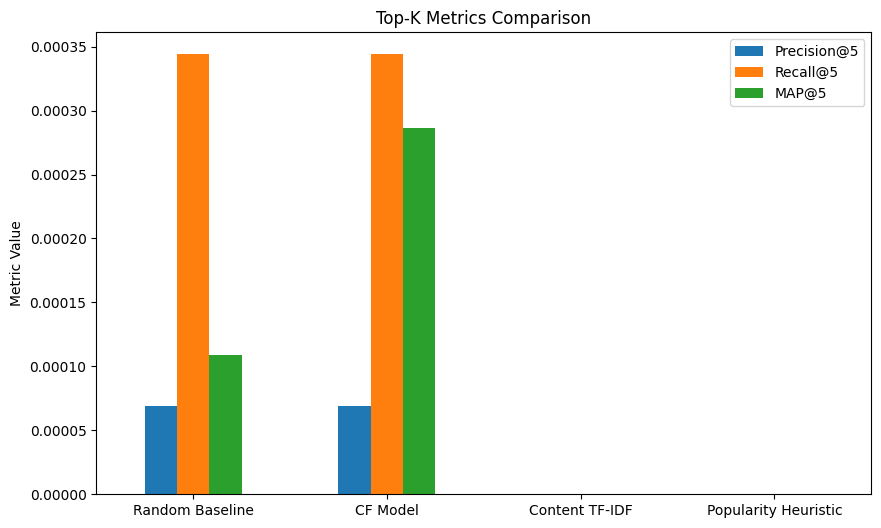

In [166]:
models = {
    "Random Baseline": user_random_recs,
    "CF Model": user_cf_recs,
    "Content TF-IDF": user_content_recs,
    "Popularity Heuristic": user_pop_recs
}

metrics_data = {}

for name, recs in models.items():
    mean_precision, mean_recall, mean_ap = print_metrics(user_test_dict, recs, name, K)
    metrics_data[name] = {
        "Precision@{}".format(K): mean_precision,
        "Recall@{}".format(K): mean_recall,
        "MAP@{}".format(K): mean_ap
    }

# Convert to DataFrame
metrics_df = pd.DataFrame(metrics_data).T

print(metrics_df)

# Plot
metrics_df.plot(kind="bar", figsize=(10,6))
plt.ylabel("Metric Value")
plt.title("Top-K Metrics Comparison")
plt.xticks(rotation=0)
plt.savefig("topk_metrics.png")
plt.show()


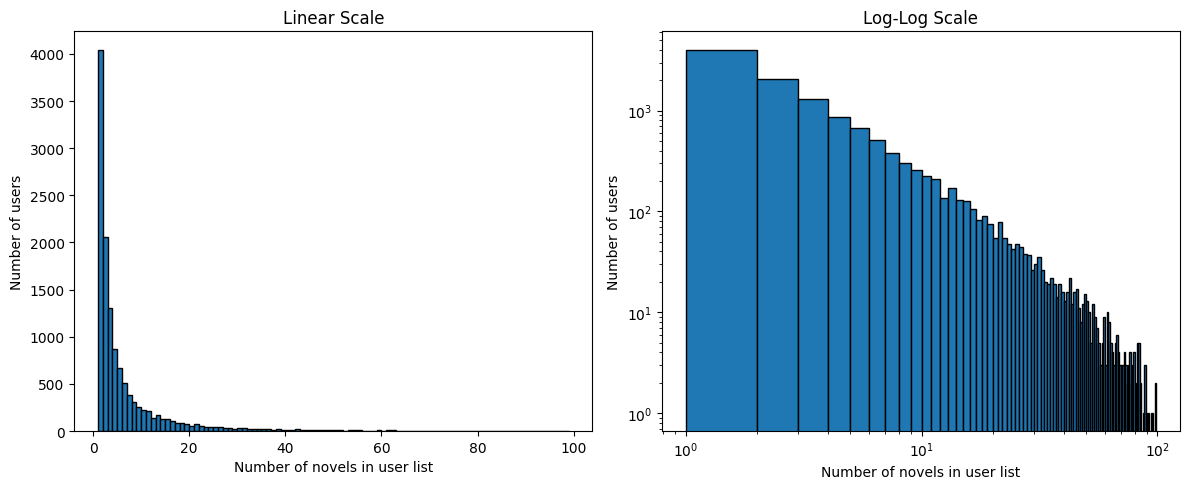

In [165]:
user_lengths = [len(v) for v in rec_dict.values()]

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Linear scale
axes[0].hist(user_lengths, bins=range(1, 100), edgecolor="black")
axes[0].set_xlabel("Number of novels in user list")
axes[0].set_ylabel("Number of users")
axes[0].set_title("Linear Scale")

# Log scale
axes[1].hist(user_lengths, bins=range(1, 100), edgecolor="black")
axes[1].set_xlabel("Number of novels in user list")
axes[1].set_ylabel("Number of users")
axes[1].set_title("Log-Log Scale")
axes[1].set_xscale("log")
axes[1].set_yscale("log")

plt.tight_layout()
plt.savefig("num_users_vs_num_novels_in_list.png")
plt.show()

In [151]:
for name, recs in models:
    print(f"--- {name} ---")
    print_metrics(user_test_dict, recs, name, K)
    print()


--- Random Baseline ---
Random Random Baseline Precision@5: 0.000046
Random Random Baseline Recall@5: 0.000229
Random Random Baseline MAP@5: 0.000115

--- CF Model ---
Random CF Model Precision@5: 0.000069
Random CF Model Recall@5: 0.000344
Random CF Model MAP@5: 0.000287

--- Content TF-IDF ---
Random Content TF-IDF Precision@5: 0.000000
Random Content TF-IDF Recall@5: 0.000000
Random Content TF-IDF MAP@5: 0.000000

--- Popularity Heuristic ---
Random Popularity Heuristic Precision@5: 0.000000
Random Popularity Heuristic Recall@5: 0.000000
Random Popularity Heuristic MAP@5: 0.000000



In [152]:
user_idx = train_df.loc[train_df["rec_id"] == "117379", "user_idx"].iloc[0]
recommended, scores = cf_model.recommend(
    user_idx,
    interaction_matrix,
    N=K,
    filter_already_liked_items=False
)
pd.DataFrame({"novel": recommended, "score": scores})

,novel,score
0,3021,0.021652
1,2543,0.011764
2,2977,0.009795
3,3592,0.007308
4,3158,0.007149


In [153]:
print(test_df)

      rec_id  novel_id
0     100007     71965
1     100010     39419
2     100021     65653
3     100025     72441
4     100027     74399
...      ...       ...
8715   99954       637
8716   99965     85009
8717   99981     15406
8718   99989     77800
8719   99991     73407

[8720 rows x 2 columns]


In [154]:
print(train_df)

       rec_id  novel_id  user_idx  item_idx
0      100007     77436         0     14051
1      100007     80797         0     14628
2      100007     88798         0     16173
3      100007     39992         0      6920
4      100007     47979         0      8507
...       ...       ...       ...       ...
71624   99991     90484      8719     16514
71625   99991     91057      8719     16627
71626   99991     92539      8719     16925
71627   99991    104340      8719     18850
71628   99991     47196      8719      8352

[71629 rows x 4 columns]


In [155]:
test_df[test_df["rec_id"] == "117379"]

,rec_id,novel_id
2748,117379,75834


In [156]:
train_df[train_df["rec_id"] == "117379"]

,rec_id,novel_id,user_idx,item_idx
28723,117379,17314,2748,2572
28724,117379,101334,2748,18423
